In [13]:

import numpy as np
from matplotlib import pyplot as plt
import math
from math import exp, sqrt,pi
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

In [14]:
eps = 1


start = 0.
end = 1.

x = np.linspace(start,end,100 )
y = np.linspace(start,end,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))

xb1 = np.linspace(start,start, 100 )
yb1 = np.linspace(start,end, 100 ) 
xb1 = xb1.reshape(-1, 1)
yb1 = yb1.reshape(-1, 1)

xb2 = np.linspace(start,end, 100 )
yb2 = np.linspace(end,end, 100 ) 
xb2 = xb2.reshape(-1, 1)
yb2 = yb2.reshape(-1, 1)

xb3 = np.linspace(end,end, 100 )
yb3 = np.linspace(start,end, 100 ) 
xb3 = xb3.reshape(-1, 1)
yb3 = yb3.reshape(-1, 1)

xb4 = np.linspace(start,end, 100 )
yb4 = np.linspace(start,start, 100 ) 
xb4 = xb4.reshape(-1, 1)
yb4 = yb4.reshape(-1, 1)

xb = [xb1,xb2,xb3,xb4]
yb = [yb1,yb2,yb3,yb4]

cos2pix = np.array([[math.cos(2*math.pi*ind[0])] for ind in x])
cos2piy = np.array([[math.cos(2*math.pi*ind[0])] for ind in y])
sinpix = np.array([[math.sin(math.pi*ind[0])] for ind in x])
sinpiy = np.array([[math.sin(math.pi*ind[0])] for ind in y])

soln = ((sinpix)**2) * ((sinpiy)**2)

#f = 8*(eps**2)*((math.pi)**4)*(cos2pix*cos2piy - cos2pix*sinpiy*sinpiy - cos2piy*sinpix*sinpix) - 2*((math.pi)**2)*(cos2pix*sinpiy*sinpiy + cos2piy*sinpix*sinpix)


In [15]:
def plot_graph(soln,soln_name):
    x = np.linspace(start,end,100);y = np.linspace(start,end,100)
    x,y = np.meshgrid(x,y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x,y,soln.reshape(100,100))
    plt.title(soln_name)
    plt.show()

In [16]:
def train(device,x,y,soln,xb,yb,eps,learning_rate,epochs,batch_flag,batch_size):
	xnet = torch.Tensor(x).to(device)
	ynet = torch.Tensor(y).to(device) 
	xb1,xb2,xb3,xb4 = xb
	yb1,yb2,yb3,yb4 = yb
	xb1 = torch.Tensor(xb1).to(device) 	
	yb1 = torch.Tensor(yb1).to(device) 
	xb2 = torch.Tensor(xb2).to(device) 	
	yb2 = torch.Tensor(yb2).to(device) 
	xb3 = torch.Tensor(xb3).to(device) 	
	yb3 = torch.Tensor(yb3).to(device) 
	xb4 = torch.Tensor(xb4).to(device) 	
	yb4 = torch.Tensor(yb4).to(device) 

	if(batch_flag):
		dataset = TensorDataset(xnet,ynet)
		dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers = 0,drop_last = True )

	h_n = 128
	input_n = 2  
	class Swish(nn.Module):
		def __init__(self, inplace=True):
			super(Swish, self).__init__()
			self.inplace = inplace

		def forward(self, x):
			if self.inplace:
				x.mul_(torch.sigmoid(x))
				return x
			else:
				return x * torch.sigmoid(x)
	

	class Net(nn.Module):
		def __init__(self):
			super(Net, self).__init__()
			self.main = nn.Sequential(
				nn.Linear(input_n,h_n),
				nn.Tanh(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
        		Swish(),
				nn.Linear(h_n,1),
			)		
		def forward(self,x):		
			output = self.main(x)
			return  output

	
	net = Net().to(device)
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	net.apply(init_normal)

	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(xnet,ynet):
		xnet.requires_grad = True
		ynet.requires_grad = True
		points = torch.cat((xnet,ynet),1) 
		U = net(points)

		U = U.view(len(U),-1)

		soln = (torch.sin(np.pi*xnet))**2 * (torch.sin(np.pi*ynet))**2
		soln_x = torch.autograd.grad(soln,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xx = torch.autograd.grad(soln_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxx = torch.autograd.grad(soln_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxxx = torch.autograd.grad(soln_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_y = torch.autograd.grad(soln,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yy = torch.autograd.grad(soln_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyy = torch.autograd.grad(soln_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyyy = torch.autograd.grad(soln_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxy = torch.autograd.grad(soln_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxyy = torch.autograd.grad(soln_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		f = (eps**2)*(soln_xxxx + soln_yyyy + 2*soln_xxyy) - (soln_xx + soln_yy)

		U_x = torch.autograd.grad(U,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxx = torch.autograd.grad(U_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxxx = torch.autograd.grad(U_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyy = torch.autograd.grad(U_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyyy = torch.autograd.grad(U_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxy = torch.autograd.grad(U_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxyy = torch.autograd.grad(U_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		loss1 = (eps**2)*(U_xxxx + U_yyyy + 2*U_xxyy) - (U_xx + U_yy) - f 
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	def Loss_BC(xb1,xb2,xb3,xb4,yb1,yb2,yb3,yb4):
		
		xb1.requires_grad = True
		yb1.requires_grad = True
		xb2.requires_grad = True
		yb2.requires_grad = True
		xb3.requires_grad = True
		yb3.requires_grad = True
		xb4.requires_grad = True
		yb4.requires_grad = True
	
		loss_f = nn.MSELoss()


		net1 = torch.cat((xb1, yb1), 1)
		out1 = net(net1)
		ub1 = out1.view(len(out1), -1)
		der_ub1 = torch.autograd.grad(ub1,xb1,grad_outputs=torch.ones_like(xb1),create_graph = True,only_inputs=True)[0]

		loss_dirichlet1 = loss_f(ub1,torch.zeros_like(ub1))
		loss_neumann1 = loss_f(der_ub1,torch.zeros_like(der_ub1))

		net2 = torch.cat((xb2, yb2), 1)
		out2 = net(net2)
		ub2 = out2.view(len(out2), -1)
		der_ub2 = torch.autograd.grad(ub2,yb2,grad_outputs=torch.ones_like(yb2),create_graph = True,only_inputs=True)[0]

		loss_dirichlet2 = loss_f(ub2,torch.zeros_like(ub2))
		loss_neumann2 = loss_f(der_ub2,torch.zeros_like(der_ub2))

		net3 = torch.cat((xb3, yb3), 1)
		out3 = net(net3)
		ub3 = out3.view(len(out3), -1)
		der_ub3 = torch.autograd.grad(ub3,xb3,grad_outputs=torch.ones_like(xb3),create_graph = True,only_inputs=True)[0]

		loss_dirichlet3 = loss_f(ub3,torch.zeros_like(ub3))
		loss_neumann3 = loss_f(der_ub3,torch.zeros_like(der_ub3))

		net4 = torch.cat((xb4, yb4), 1)
		out4 = net(net4)
		ub4 = out4.view(len(out4), -1)
		der_ub4 = torch.autograd.grad(ub4,yb4,grad_outputs=torch.ones_like(yb4),create_graph = True,only_inputs=True)[0]

		loss_dirichlet4 = loss_f(ub4,torch.zeros_like(ub4))
		loss_neumann4 = loss_f(der_ub4,torch.zeros_like(der_ub4))

		total_loss = loss_dirichlet1 + loss_neumann1 + loss_dirichlet2 + loss_neumann2 + loss_dirichlet3 + loss_neumann3 + loss_dirichlet4 + loss_neumann4 
		return total_loss

	losses = []
	tic = time.time()


	if(batch_flag):
		for epoch in range(epochs):
			if epoch == 40:
				learning_rate = 0.0001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
			for batch_idx, (x_in,y_in) in enumerate(dataloader):

				net.zero_grad()
				loss_eqn = Loss_criterion(x_in,y_in)
				loss_bc = Loss_BC(xb1,xb2,xb3,xb4,yb1,yb2,yb3,yb4)
				loss = loss_eqn + loss_bc
				loss.backward()

				optimizer.step() 
				if batch_idx % 20 ==0:
					print('Train Epoch: {} \nTotal Loss: {:.10f} \tCriterion Loss: {:.10f} \tBoundary Condition Loss {:.6f}'.format(
					epoch, loss.item(),loss_eqn.item(),loss_bc.item()))

			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(soln - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.10f}\n'.format(
				epoch, actual_loss))
			if epoch % 1 == 0:
				plot_graph(z,'Predicted solution')
			
			losses.append([loss.item(),actual_loss])
	else:
		for epoch in range(epochs):
			if epoch == 100:
				learning_rate = 0.0001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer

			net.zero_grad()
			loss_eqn = Loss_criterion(xnet,ynet)
			loss_bc = Loss_BC(xb1,xb2,xb3,xb4,yb1,yb2,yb3,yb4)
			loss = loss_eqn + loss_bc
			loss.backward()
			
			optimizer.step() 
			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(soln - z).mean()
			if epoch % 5 == 0:
				plot_graph(z,"soln")
			print('Train Epoch: {} \nTotal Loss: {:.10f} \tCriterion Loss: {:.10f} \tBoundary Condition Loss {:.6f}\nActual loss: {:.6f}'.format(
				epoch, loss.item(),loss_eqn.item(),loss_bc.item(),actual_loss))
			losses.append([loss.item(),loss_eqn.item(),loss_bc.item(),actual_loss])

	toc = time.time()
	elapseTime = toc - tic
	print ("elapse time in parallel = ", elapseTime)

	net_in = torch.cat((xnet,ynet),1)
	output = net(net_in)  
	
	return output 




Train Epoch: 0 
Total Loss: 640816.6875000000 	Criterion Loss: 640816.5000000000 	Boundary Condition Loss 0.196915
Train Epoch: 0 
Total Loss: 211718.8906250000 	Criterion Loss: 211703.2812500000 	Boundary Condition Loss 15.606113
Train Epoch: 0 
Total Loss: 47203.8750000000 	Criterion Loss: 47171.3320312500 	Boundary Condition Loss 32.541168
Train Epoch: 0 
Total Loss: 10567.0097656250 	Criterion Loss: 10533.8457031250 	Boundary Condition Loss 33.163754

After Epoch 0, 	 Actual solution loss: 1.8025658470



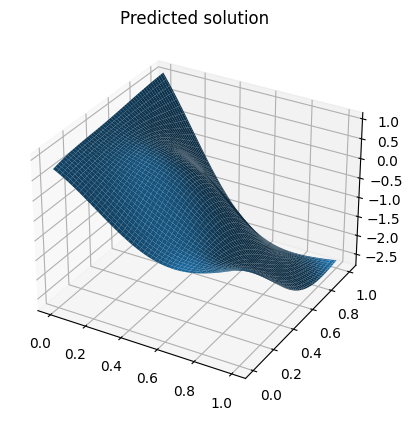

Train Epoch: 1 
Total Loss: 4154.6679687500 	Criterion Loss: 4122.3706054688 	Boundary Condition Loss 32.297253
Train Epoch: 1 
Total Loss: 2383.9328613281 	Criterion Loss: 2354.7844238281 	Boundary Condition Loss 29.148512
Train Epoch: 1 
Total Loss: 2193.9519042969 	Criterion Loss: 2167.1921386719 	Boundary Condition Loss 26.759750
Train Epoch: 1 
Total Loss: 641.3358764648 	Criterion Loss: 615.9696655273 	Boundary Condition Loss 25.366188

After Epoch 1, 	 Actual solution loss: 1.2166041305



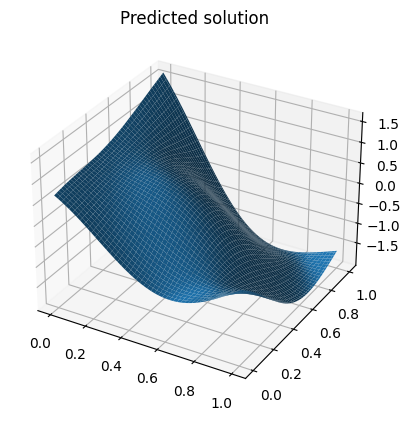

Train Epoch: 2 
Total Loss: 354.8367919922 	Criterion Loss: 330.6593322754 	Boundary Condition Loss 24.177444
Train Epoch: 2 
Total Loss: 2592.0947265625 	Criterion Loss: 2568.6613769531 	Boundary Condition Loss 23.433365
Train Epoch: 2 
Total Loss: 555.6892089844 	Criterion Loss: 533.2640991211 	Boundary Condition Loss 22.425100
Train Epoch: 2 
Total Loss: 684.8652343750 	Criterion Loss: 663.8197631836 	Boundary Condition Loss 21.045454

After Epoch 2, 	 Actual solution loss: 0.9380761305



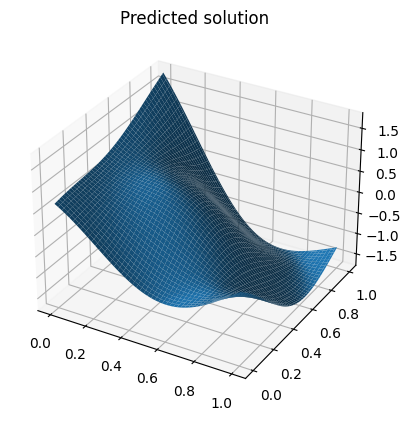

Train Epoch: 3 
Total Loss: 1214.6717529297 	Criterion Loss: 1193.2899169922 	Boundary Condition Loss 21.381847
Train Epoch: 3 
Total Loss: 3097.4543457031 	Criterion Loss: 3078.9814453125 	Boundary Condition Loss 18.472836
Train Epoch: 3 
Total Loss: 2062.3249511719 	Criterion Loss: 2043.0892333984 	Boundary Condition Loss 19.235620
Train Epoch: 3 
Total Loss: 1146.8963623047 	Criterion Loss: 1130.2928466797 	Boundary Condition Loss 16.603540

After Epoch 3, 	 Actual solution loss: 0.5815349641



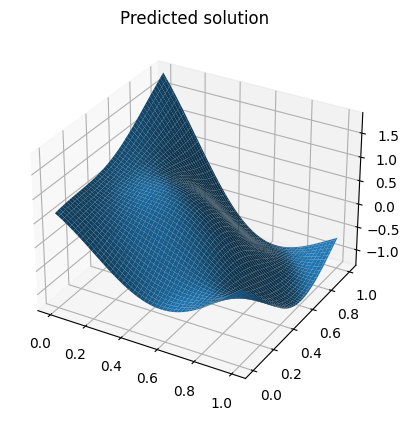

Train Epoch: 4 
Total Loss: 441.5282592773 	Criterion Loss: 423.9870605469 	Boundary Condition Loss 17.541189
Train Epoch: 4 
Total Loss: 1545.9687500000 	Criterion Loss: 1529.7204589844 	Boundary Condition Loss 16.248260
Train Epoch: 4 
Total Loss: 842.9564819336 	Criterion Loss: 826.1090087891 	Boundary Condition Loss 16.847460
Train Epoch: 4 
Total Loss: 377.3267822266 	Criterion Loss: 361.2340698242 	Boundary Condition Loss 16.092697

After Epoch 4, 	 Actual solution loss: 0.4198876693



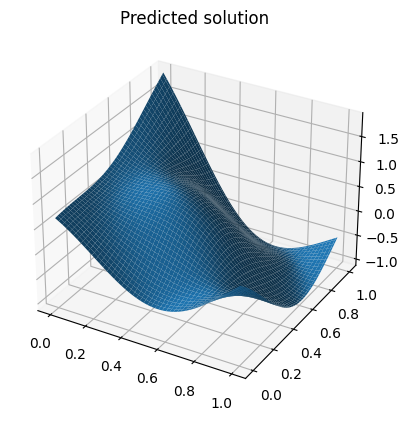

Train Epoch: 5 
Total Loss: 296.2196960449 	Criterion Loss: 280.2776794434 	Boundary Condition Loss 15.942018
Train Epoch: 5 
Total Loss: 823.2908325195 	Criterion Loss: 807.1375122070 	Boundary Condition Loss 16.153341
Train Epoch: 5 
Total Loss: 872.8264160156 	Criterion Loss: 857.4997558594 	Boundary Condition Loss 15.326659
Train Epoch: 5 
Total Loss: 1518.2561035156 	Criterion Loss: 1502.5676269531 	Boundary Condition Loss 15.688416

After Epoch 5, 	 Actual solution loss: 0.2834780615



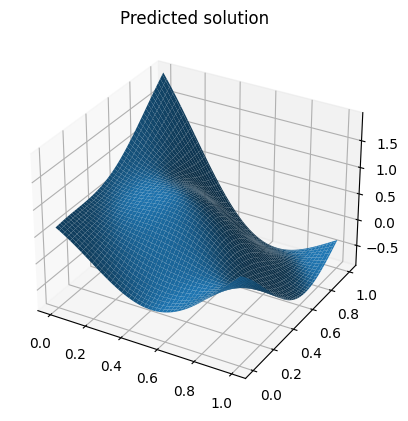

Train Epoch: 6 
Total Loss: 6141.4316406250 	Criterion Loss: 6127.3154296875 	Boundary Condition Loss 14.116092
Train Epoch: 6 
Total Loss: 1390.1973876953 	Criterion Loss: 1374.6870117188 	Boundary Condition Loss 15.510365
Train Epoch: 6 
Total Loss: 3760.3491210938 	Criterion Loss: 3745.6811523438 	Boundary Condition Loss 14.667944
Train Epoch: 6 
Total Loss: 724.5185546875 	Criterion Loss: 708.6434326172 	Boundary Condition Loss 15.875150

After Epoch 6, 	 Actual solution loss: 0.2824252706



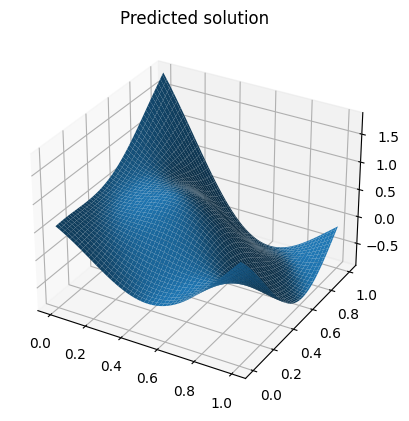

Train Epoch: 7 
Total Loss: 309.7684936523 	Criterion Loss: 294.6208801270 	Boundary Condition Loss 15.147628
Train Epoch: 7 
Total Loss: 181.0732116699 	Criterion Loss: 165.8832244873 	Boundary Condition Loss 15.189986
Train Epoch: 7 
Total Loss: 126.2337188721 	Criterion Loss: 111.4641113281 	Boundary Condition Loss 14.769608
Train Epoch: 7 
Total Loss: 297.9587707520 	Criterion Loss: 283.2477722168 	Boundary Condition Loss 14.710992

After Epoch 7, 	 Actual solution loss: 0.2691342581



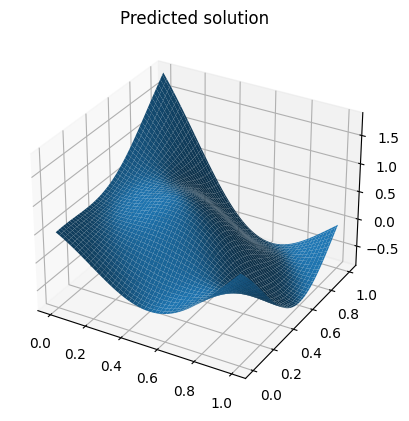

Train Epoch: 8 
Total Loss: 423.9052429199 	Criterion Loss: 410.0858764648 	Boundary Condition Loss 13.819367
Train Epoch: 8 
Total Loss: 589.9216308594 	Criterion Loss: 575.9090576172 	Boundary Condition Loss 14.012574
Train Epoch: 8 
Total Loss: 1394.8707275391 	Criterion Loss: 1381.8968505859 	Boundary Condition Loss 12.973819
Train Epoch: 8 
Total Loss: 3039.8049316406 	Criterion Loss: 3025.9182128906 	Boundary Condition Loss 13.886689

After Epoch 8, 	 Actual solution loss: 0.2533959349



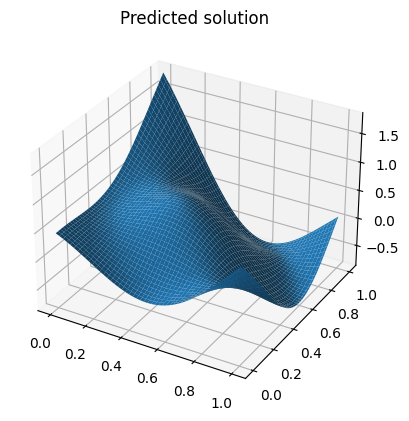

Train Epoch: 9 
Total Loss: 1481.8931884766 	Criterion Loss: 1467.5874023438 	Boundary Condition Loss 14.305766
Train Epoch: 9 
Total Loss: 4884.6152343750 	Criterion Loss: 4868.1640625000 	Boundary Condition Loss 16.451342
Train Epoch: 9 
Total Loss: 1783.2191162109 	Criterion Loss: 1769.5300292969 	Boundary Condition Loss 13.689059
Train Epoch: 9 
Total Loss: 205.8632965088 	Criterion Loss: 191.5818634033 	Boundary Condition Loss 14.281435

After Epoch 9, 	 Actual solution loss: 0.2908356496



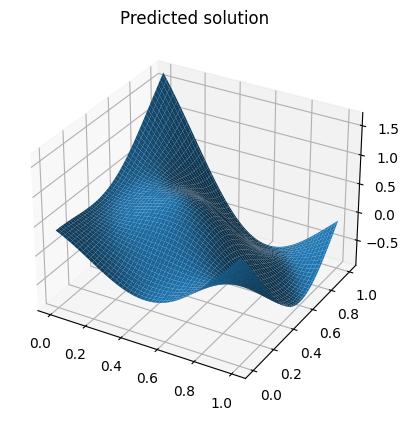

Train Epoch: 10 
Total Loss: 363.2475280762 	Criterion Loss: 348.9643554688 	Boundary Condition Loss 14.283176
Train Epoch: 10 
Total Loss: 74.0605621338 	Criterion Loss: 59.6197891235 	Boundary Condition Loss 14.440771
Train Epoch: 10 
Total Loss: 71.2115631104 	Criterion Loss: 57.2012176514 	Boundary Condition Loss 14.010345
Train Epoch: 10 
Total Loss: 1778.1541748047 	Criterion Loss: 1765.0915527344 	Boundary Condition Loss 13.062641

After Epoch 10, 	 Actual solution loss: 0.2902188192



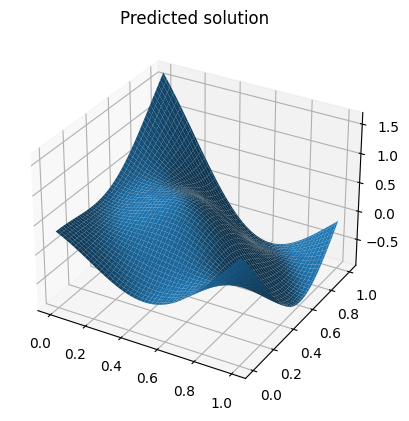

Train Epoch: 11 
Total Loss: 593.2825927734 	Criterion Loss: 579.3851318359 	Boundary Condition Loss 13.897485
Train Epoch: 11 
Total Loss: 1056.6923828125 	Criterion Loss: 1043.1102294922 	Boundary Condition Loss 13.582136
Train Epoch: 11 
Total Loss: 3142.0390625000 	Criterion Loss: 3127.4648437500 	Boundary Condition Loss 14.574139
Train Epoch: 11 
Total Loss: 1110.0024414062 	Criterion Loss: 1095.5935058594 	Boundary Condition Loss 14.408963

After Epoch 11, 	 Actual solution loss: 0.3032465145



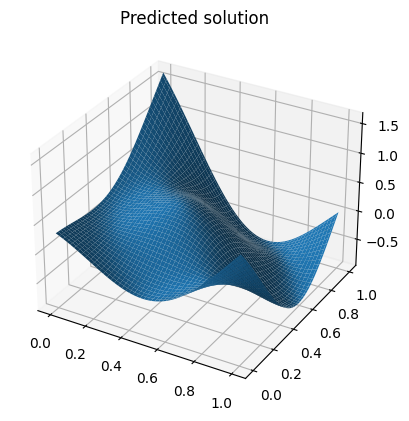

Train Epoch: 12 
Total Loss: 832.5192260742 	Criterion Loss: 817.4256591797 	Boundary Condition Loss 15.093542
Train Epoch: 12 
Total Loss: 944.1343994141 	Criterion Loss: 930.2113037109 	Boundary Condition Loss 13.923121
Train Epoch: 12 
Total Loss: 585.3703613281 	Criterion Loss: 572.2862548828 	Boundary Condition Loss 13.084109
Train Epoch: 12 
Total Loss: 727.7917480469 	Criterion Loss: 714.5677490234 	Boundary Condition Loss 13.224026

After Epoch 12, 	 Actual solution loss: 0.2877432183



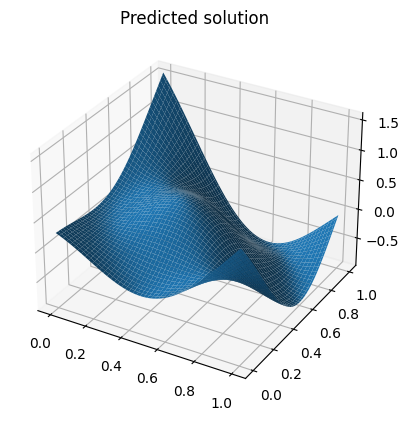

Train Epoch: 13 
Total Loss: 342.9582519531 	Criterion Loss: 328.9734802246 	Boundary Condition Loss 13.984770
Train Epoch: 13 
Total Loss: 6348.5327148438 	Criterion Loss: 6335.9199218750 	Boundary Condition Loss 12.613035
Train Epoch: 13 
Total Loss: 1291.4801025391 	Criterion Loss: 1277.5187988281 	Boundary Condition Loss 13.961257
Train Epoch: 13 
Total Loss: 223.4371643066 	Criterion Loss: 208.9986114502 	Boundary Condition Loss 14.438551

After Epoch 13, 	 Actual solution loss: 0.3143243006



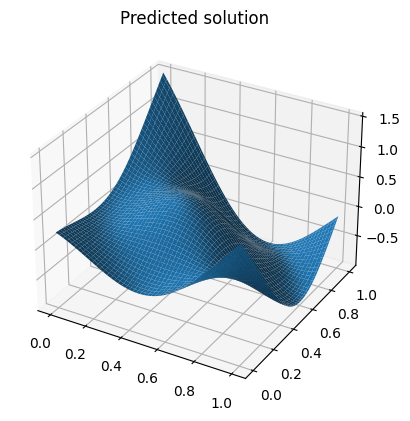

Train Epoch: 14 
Total Loss: 139.9383544922 	Criterion Loss: 126.0232925415 	Boundary Condition Loss 13.915062
Train Epoch: 14 
Total Loss: 116.1239547729 	Criterion Loss: 101.7303924561 	Boundary Condition Loss 14.393562
Train Epoch: 14 
Total Loss: 1379.4624023438 	Criterion Loss: 1366.2929687500 	Boundary Condition Loss 13.169450
Train Epoch: 14 
Total Loss: 683.3293457031 	Criterion Loss: 670.3718261719 	Boundary Condition Loss 12.957520

After Epoch 14, 	 Actual solution loss: 0.2848850995



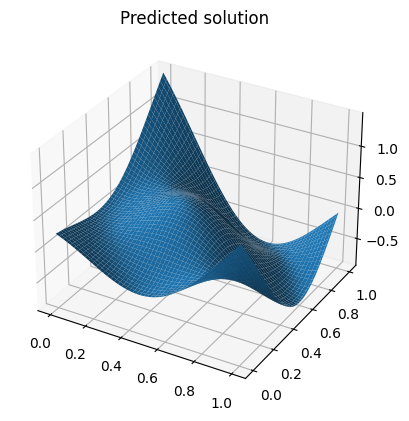

Train Epoch: 15 
Total Loss: 170.3352050781 	Criterion Loss: 156.8019256592 	Boundary Condition Loss 13.533282
Train Epoch: 15 
Total Loss: 240.3726959229 	Criterion Loss: 227.5880584717 	Boundary Condition Loss 12.784643
Train Epoch: 15 
Total Loss: 972.2728271484 	Criterion Loss: 958.5953979492 	Boundary Condition Loss 13.677449
Train Epoch: 15 
Total Loss: 6480.5151367188 	Criterion Loss: 6469.4716796875 	Boundary Condition Loss 11.043419

After Epoch 15, 	 Actual solution loss: 0.3837734176



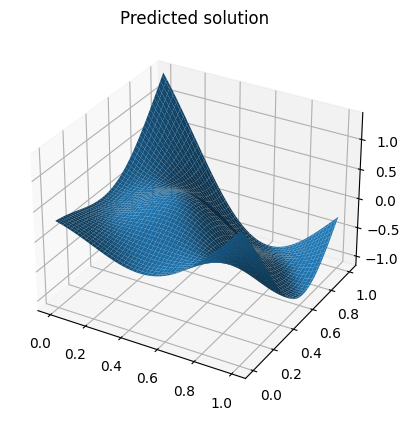

Train Epoch: 16 
Total Loss: 6111.5009765625 	Criterion Loss: 6096.5581054688 	Boundary Condition Loss 14.942678
Train Epoch: 16 
Total Loss: 1313.9042968750 	Criterion Loss: 1299.2348632812 	Boundary Condition Loss 14.669411
Train Epoch: 16 
Total Loss: 555.3257446289 	Criterion Loss: 539.8630371094 	Boundary Condition Loss 15.462712
Train Epoch: 16 
Total Loss: 453.4357910156 	Criterion Loss: 437.7033996582 	Boundary Condition Loss 15.732402

After Epoch 16, 	 Actual solution loss: 0.2919382479



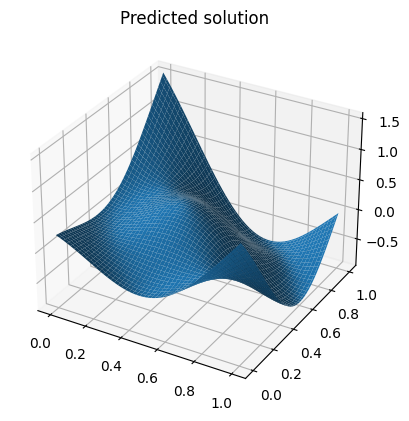

Train Epoch: 17 
Total Loss: 157.0027618408 	Criterion Loss: 142.3451690674 	Boundary Condition Loss 14.657594
Train Epoch: 17 
Total Loss: 161.6235351562 	Criterion Loss: 147.0042724609 	Boundary Condition Loss 14.619257
Train Epoch: 17 
Total Loss: 74.9118957520 	Criterion Loss: 60.3935127258 	Boundary Condition Loss 14.518379
Train Epoch: 17 
Total Loss: 70.7801055908 	Criterion Loss: 56.6651153564 	Boundary Condition Loss 14.114990

After Epoch 17, 	 Actual solution loss: 0.3005481516



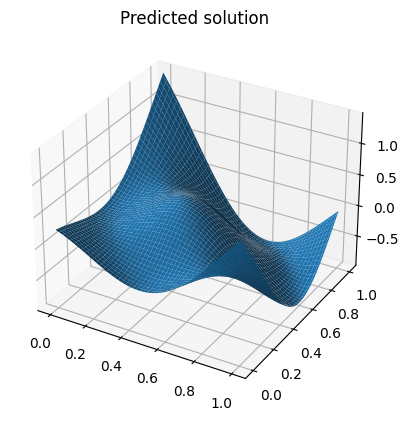

Train Epoch: 18 
Total Loss: 171.8871154785 	Criterion Loss: 157.7934570312 	Boundary Condition Loss 14.093657
Train Epoch: 18 
Total Loss: 200.5134887695 	Criterion Loss: 186.9292297363 	Boundary Condition Loss 13.584255
Train Epoch: 18 
Total Loss: 130.2949218750 	Criterion Loss: 117.2734832764 	Boundary Condition Loss 13.021431
Train Epoch: 18 
Total Loss: 11759.0400390625 	Criterion Loss: 11743.4316406250 	Boundary Condition Loss 15.608623

After Epoch 18, 	 Actual solution loss: 0.1883755549



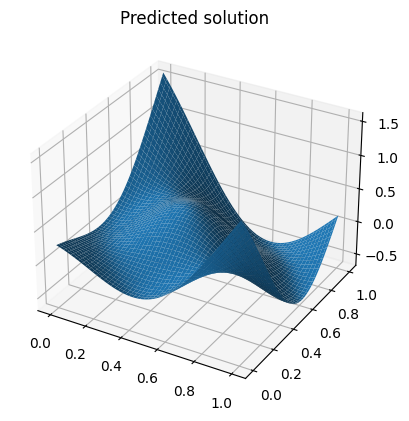

Train Epoch: 19 
Total Loss: 1981.7082519531 	Criterion Loss: 1967.0190429688 	Boundary Condition Loss 14.689156
Train Epoch: 19 
Total Loss: 1381.3433837891 	Criterion Loss: 1367.1391601562 	Boundary Condition Loss 14.204167
Train Epoch: 19 
Total Loss: 477.9979858398 	Criterion Loss: 464.6953735352 	Boundary Condition Loss 13.302628
Train Epoch: 19 
Total Loss: 333.8166198730 	Criterion Loss: 320.0736083984 	Boundary Condition Loss 13.743001

After Epoch 19, 	 Actual solution loss: 0.3140737097



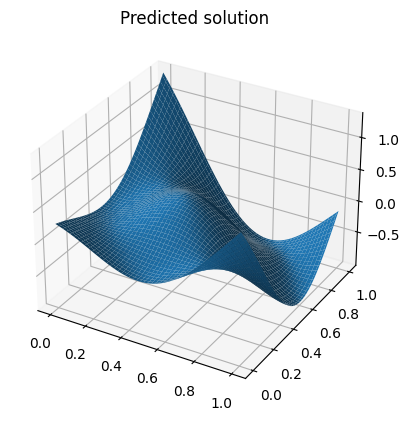

Train Epoch: 20 
Total Loss: 161.5623626709 	Criterion Loss: 148.1604003906 	Boundary Condition Loss 13.401959
Train Epoch: 20 
Total Loss: 226.2726593018 	Criterion Loss: 213.5257415771 	Boundary Condition Loss 12.746922
Train Epoch: 20 
Total Loss: 2260.0478515625 	Criterion Loss: 2246.4934082031 	Boundary Condition Loss 13.554470
Train Epoch: 20 
Total Loss: 1363.5953369141 	Criterion Loss: 1350.4680175781 	Boundary Condition Loss 13.127303

After Epoch 20, 	 Actual solution loss: 0.2801530067



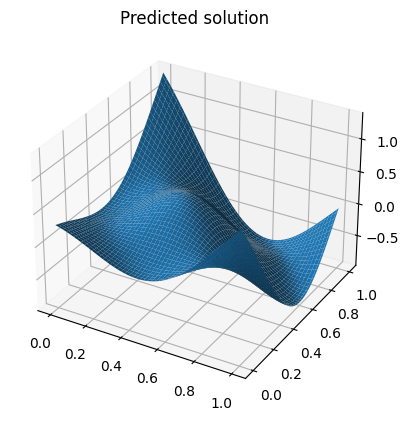

Train Epoch: 21 
Total Loss: 929.9071044922 	Criterion Loss: 916.7056884766 	Boundary Condition Loss 13.201415
Train Epoch: 21 
Total Loss: 575.2767944336 	Criterion Loss: 562.5347290039 	Boundary Condition Loss 12.742050
Train Epoch: 21 
Total Loss: 361.3064575195 	Criterion Loss: 349.0572509766 	Boundary Condition Loss 12.249193
Train Epoch: 21 
Total Loss: 1887.2744140625 	Criterion Loss: 1876.2343750000 	Boundary Condition Loss 11.039981

After Epoch 21, 	 Actual solution loss: 0.2255607316



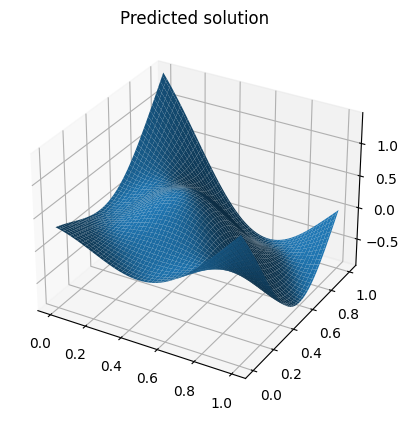

Train Epoch: 22 
Total Loss: 384.2645568848 	Criterion Loss: 372.3670043945 	Boundary Condition Loss 11.897543
Train Epoch: 22 
Total Loss: 446.8553161621 	Criterion Loss: 433.7890625000 	Boundary Condition Loss 13.066259
Train Epoch: 22 
Total Loss: 347.5086669922 	Criterion Loss: 335.0799865723 	Boundary Condition Loss 12.428693
Train Epoch: 22 
Total Loss: 928.2949829102 	Criterion Loss: 915.9104003906 	Boundary Condition Loss 12.384576

After Epoch 22, 	 Actual solution loss: 0.2584228804



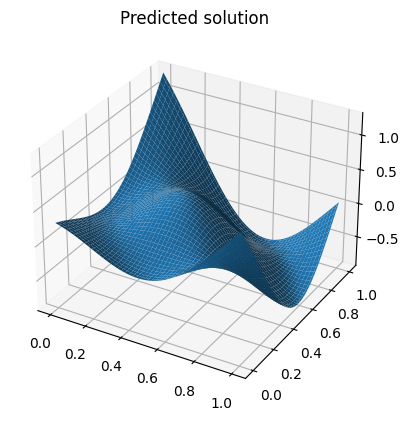

Train Epoch: 23 
Total Loss: 1110.9460449219 	Criterion Loss: 1098.8394775391 	Boundary Condition Loss 12.106627
Train Epoch: 23 
Total Loss: 3491.8955078125 	Criterion Loss: 3478.9204101562 	Boundary Condition Loss 12.975026
Train Epoch: 23 
Total Loss: 1076.6231689453 	Criterion Loss: 1063.4959716797 	Boundary Condition Loss 13.127199
Train Epoch: 23 
Total Loss: 578.7777099609 	Criterion Loss: 567.1632080078 	Boundary Condition Loss 11.614491

After Epoch 23, 	 Actual solution loss: 0.3146201720



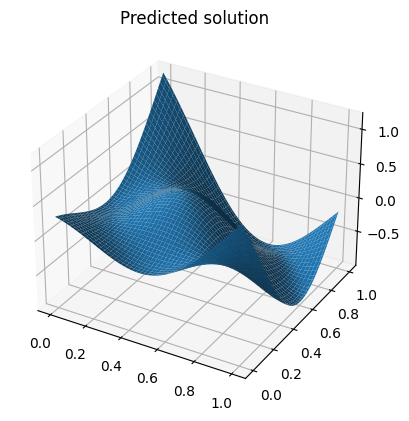

Train Epoch: 24 
Total Loss: 1288.6263427734 	Criterion Loss: 1276.2937011719 	Boundary Condition Loss 12.332611
Train Epoch: 24 
Total Loss: 2086.7048339844 	Criterion Loss: 2074.5473632812 	Boundary Condition Loss 12.157491
Train Epoch: 24 
Total Loss: 432.7490539551 	Criterion Loss: 420.2930297852 	Boundary Condition Loss 12.456037
Train Epoch: 24 
Total Loss: 506.8496093750 	Criterion Loss: 493.5427856445 	Boundary Condition Loss 13.306827

After Epoch 24, 	 Actual solution loss: 0.2776116810



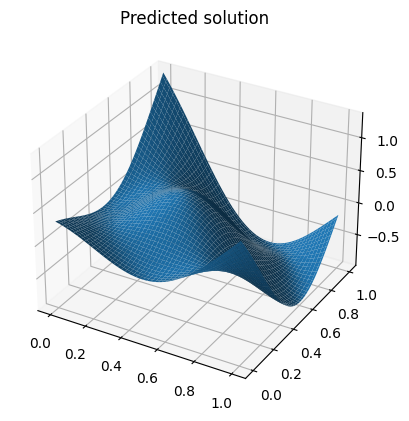

Train Epoch: 25 
Total Loss: 874.8798828125 	Criterion Loss: 863.2487792969 	Boundary Condition Loss 11.631078
Train Epoch: 25 
Total Loss: 197.9192810059 	Criterion Loss: 185.2400207520 	Boundary Condition Loss 12.679262
Train Epoch: 25 
Total Loss: 201.1111297607 	Criterion Loss: 188.7138671875 	Boundary Condition Loss 12.397265
Train Epoch: 25 
Total Loss: 164.0837707520 	Criterion Loss: 151.6560516357 	Boundary Condition Loss 12.427716

After Epoch 25, 	 Actual solution loss: 0.2483603005



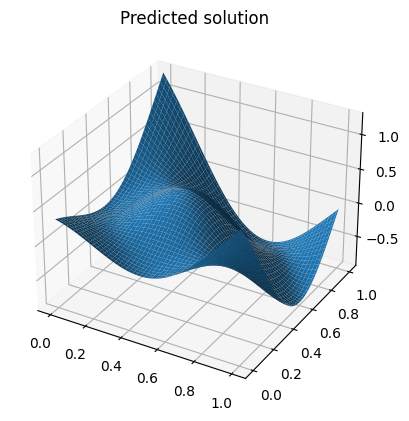

Train Epoch: 26 
Total Loss: 149.9267120361 	Criterion Loss: 138.3599090576 	Boundary Condition Loss 11.566797
Train Epoch: 26 
Total Loss: 205.2756652832 	Criterion Loss: 193.4595336914 	Boundary Condition Loss 11.816134
Train Epoch: 26 
Total Loss: 782.7669067383 	Criterion Loss: 772.0059814453 	Boundary Condition Loss 10.760901
Train Epoch: 26 
Total Loss: 325.0524597168 	Criterion Loss: 314.2172241211 	Boundary Condition Loss 10.835250

After Epoch 26, 	 Actual solution loss: 0.2295673722



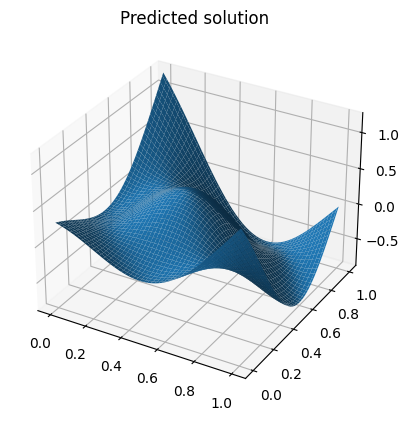

Train Epoch: 27 
Total Loss: 496.8168945312 	Criterion Loss: 485.6138916016 	Boundary Condition Loss 11.203003
Train Epoch: 27 
Total Loss: 5796.5219726562 	Criterion Loss: 5782.6826171875 	Boundary Condition Loss 13.839361
Train Epoch: 27 
Total Loss: 3885.3054199219 	Criterion Loss: 3874.2861328125 	Boundary Condition Loss 11.019387
Train Epoch: 27 
Total Loss: 1389.4152832031 	Criterion Loss: 1376.1622314453 	Boundary Condition Loss 13.252995

After Epoch 27, 	 Actual solution loss: 0.2882664692



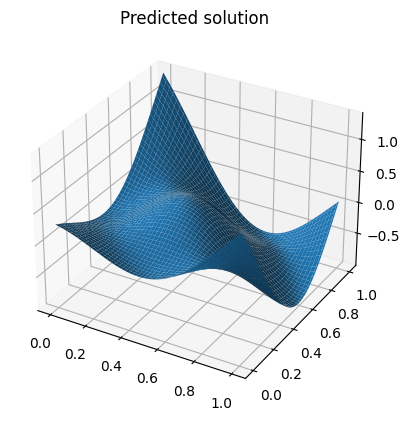

Train Epoch: 28 
Total Loss: 229.8225555420 	Criterion Loss: 215.5249786377 	Boundary Condition Loss 14.297577
Train Epoch: 28 
Total Loss: 130.3883056641 	Criterion Loss: 116.3497314453 	Boundary Condition Loss 14.038571
Train Epoch: 28 
Total Loss: 62.7654037476 	Criterion Loss: 49.1918869019 	Boundary Condition Loss 13.573515
Train Epoch: 28 
Total Loss: 107.3742980957 	Criterion Loss: 94.5233688354 	Boundary Condition Loss 12.850933

After Epoch 28, 	 Actual solution loss: 0.2571234914



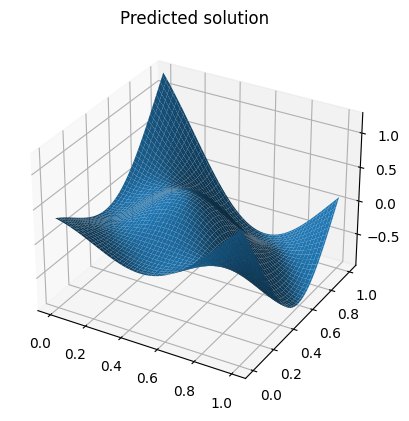

Train Epoch: 29 
Total Loss: 71.3651504517 	Criterion Loss: 58.6635093689 	Boundary Condition Loss 12.701640
Train Epoch: 29 
Total Loss: 132.1669158936 	Criterion Loss: 119.5340042114 	Boundary Condition Loss 12.632915
Train Epoch: 29 
Total Loss: 167.4341125488 	Criterion Loss: 155.7403106689 	Boundary Condition Loss 11.693796
Train Epoch: 29 
Total Loss: 212.1327514648 	Criterion Loss: 200.5485229492 	Boundary Condition Loss 11.584231

After Epoch 29, 	 Actual solution loss: 0.2537240251



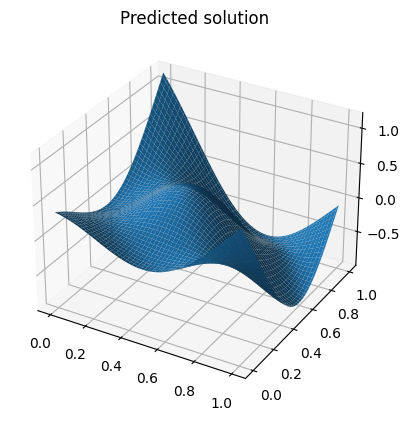

Train Epoch: 30 
Total Loss: 2185.5717773438 	Criterion Loss: 2174.3129882812 	Boundary Condition Loss 11.258829
Train Epoch: 30 
Total Loss: 1101.1604003906 	Criterion Loss: 1089.9664306641 	Boundary Condition Loss 11.193947
Train Epoch: 30 
Total Loss: 935.6118774414 	Criterion Loss: 923.3783569336 	Boundary Condition Loss 12.233523
Train Epoch: 30 
Total Loss: 566.1632690430 	Criterion Loss: 554.7438354492 	Boundary Condition Loss 11.419448

After Epoch 30, 	 Actual solution loss: 0.2635254542



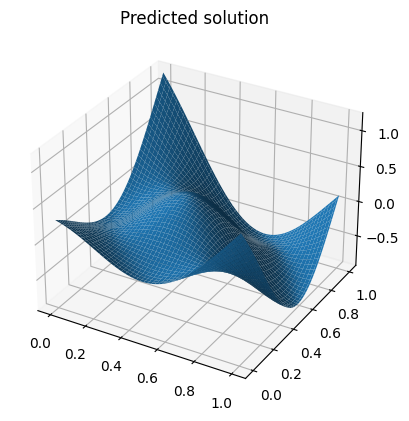

Train Epoch: 31 
Total Loss: 183.5459747314 	Criterion Loss: 171.0422973633 	Boundary Condition Loss 12.503679
Train Epoch: 31 
Total Loss: 86.1009521484 	Criterion Loss: 74.1983261108 	Boundary Condition Loss 11.902624
Train Epoch: 31 
Total Loss: 116.0016250610 	Criterion Loss: 103.9988555908 	Boundary Condition Loss 12.002767
Train Epoch: 31 
Total Loss: 67.2858123779 	Criterion Loss: 55.9610671997 	Boundary Condition Loss 11.324744

After Epoch 31, 	 Actual solution loss: 0.2288828506



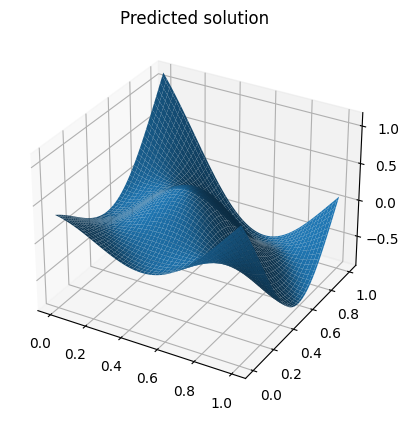

Train Epoch: 32 
Total Loss: 89.1230545044 	Criterion Loss: 78.1686477661 	Boundary Condition Loss 10.954408
Train Epoch: 32 
Total Loss: 103.2820129395 	Criterion Loss: 92.6086502075 	Boundary Condition Loss 10.673361
Train Epoch: 32 
Total Loss: 409.8869628906 	Criterion Loss: 400.0764465332 	Boundary Condition Loss 9.810506
Train Epoch: 32 
Total Loss: 591.2988891602 	Criterion Loss: 580.1498413086 	Boundary Condition Loss 11.149029

After Epoch 32, 	 Actual solution loss: 0.2391036448



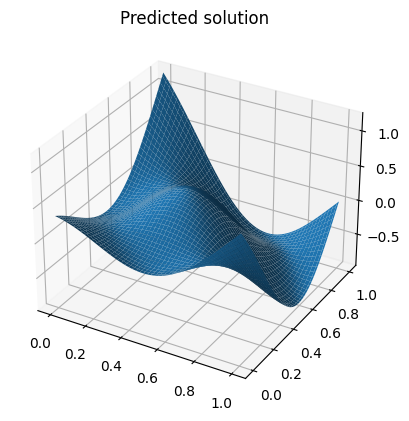

Train Epoch: 33 
Total Loss: 451.3043212891 	Criterion Loss: 440.2775268555 	Boundary Condition Loss 11.026808
Train Epoch: 33 
Total Loss: 230.7049255371 	Criterion Loss: 219.7318725586 	Boundary Condition Loss 10.973053
Train Epoch: 33 
Total Loss: 758.1512451172 	Criterion Loss: 746.3616943359 	Boundary Condition Loss 11.789559
Train Epoch: 33 
Total Loss: 115.3198089600 	Criterion Loss: 104.4848251343 	Boundary Condition Loss 10.834984

After Epoch 33, 	 Actual solution loss: 0.2080857718



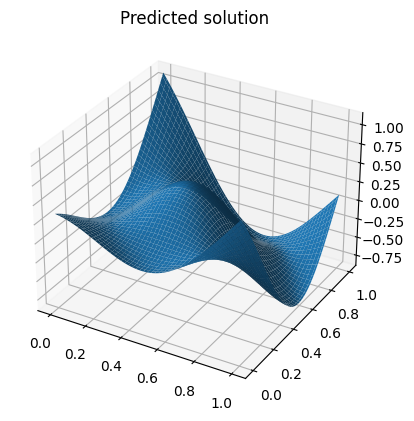

Train Epoch: 34 
Total Loss: 215.1698303223 	Criterion Loss: 204.6761322021 	Boundary Condition Loss 10.493695
Train Epoch: 34 
Total Loss: 81.6998214722 	Criterion Loss: 71.6579284668 	Boundary Condition Loss 10.041894
Train Epoch: 34 
Total Loss: 341.7694091797 	Criterion Loss: 332.1251220703 	Boundary Condition Loss 9.644301
Train Epoch: 34 
Total Loss: 1750.4135742188 	Criterion Loss: 1741.4271240234 	Boundary Condition Loss 8.986393

After Epoch 34, 	 Actual solution loss: 0.2322308431



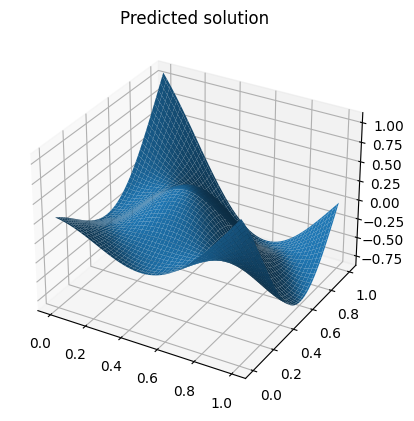

Train Epoch: 35 
Total Loss: 1319.1483154297 	Criterion Loss: 1308.9919433594 	Boundary Condition Loss 10.156359
Train Epoch: 35 
Total Loss: 845.9063110352 	Criterion Loss: 835.2767944336 	Boundary Condition Loss 10.629537
Train Epoch: 35 
Total Loss: 424.0361328125 	Criterion Loss: 413.8920288086 	Boundary Condition Loss 10.144099
Train Epoch: 35 
Total Loss: 143.6179656982 	Criterion Loss: 133.0048828125 	Boundary Condition Loss 10.613082

After Epoch 35, 	 Actual solution loss: 0.2055004761



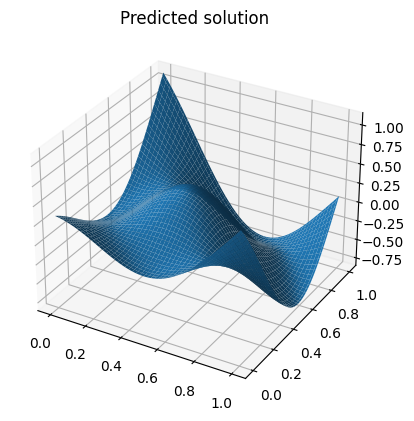

Train Epoch: 36 
Total Loss: 162.4686889648 	Criterion Loss: 152.6405944824 	Boundary Condition Loss 9.828096
Train Epoch: 36 
Total Loss: 265.0887451172 	Criterion Loss: 255.4154663086 	Boundary Condition Loss 9.673282
Train Epoch: 36 
Total Loss: 398.4673767090 	Criterion Loss: 388.1637268066 	Boundary Condition Loss 10.303636
Train Epoch: 36 
Total Loss: 670.1762084961 	Criterion Loss: 660.7766723633 	Boundary Condition Loss 9.399542

After Epoch 36, 	 Actual solution loss: 0.2043599001



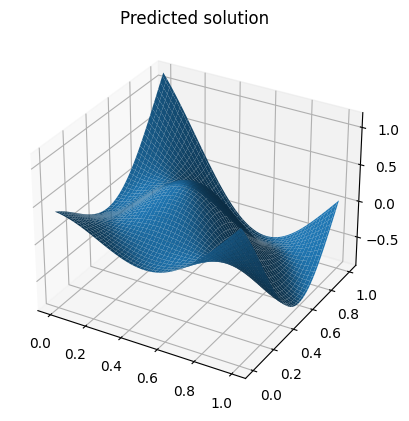

Train Epoch: 37 
Total Loss: 186.1475372314 	Criterion Loss: 176.3299255371 	Boundary Condition Loss 9.817616
Train Epoch: 37 
Total Loss: 506.6001892090 	Criterion Loss: 496.5113830566 	Boundary Condition Loss 10.088815
Train Epoch: 37 
Total Loss: 1993.1672363281 	Criterion Loss: 1983.5632324219 	Boundary Condition Loss 9.604012
Train Epoch: 37 
Total Loss: 174.9090728760 	Criterion Loss: 165.0391998291 	Boundary Condition Loss 9.869879

After Epoch 37, 	 Actual solution loss: 0.2050424527



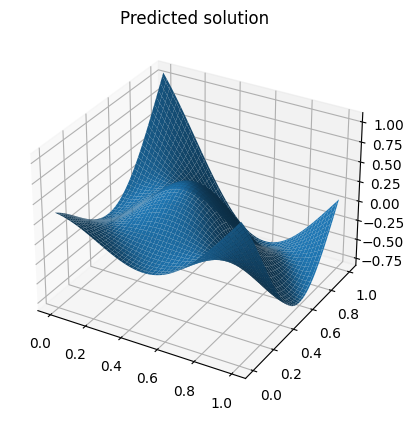

Train Epoch: 38 
Total Loss: 171.7133483887 	Criterion Loss: 162.0404510498 	Boundary Condition Loss 9.672892
Train Epoch: 38 
Total Loss: 170.1714324951 	Criterion Loss: 160.1866455078 	Boundary Condition Loss 9.984785
Train Epoch: 38 
Total Loss: 48.1948051453 	Criterion Loss: 38.8339729309 	Boundary Condition Loss 9.360831
Train Epoch: 38 
Total Loss: 71.1135711670 	Criterion Loss: 62.3115234375 	Boundary Condition Loss 8.802044

After Epoch 38, 	 Actual solution loss: 0.1993771942



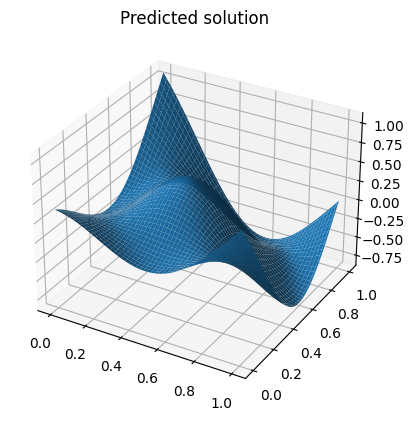

Train Epoch: 39 
Total Loss: 247.5864105225 	Criterion Loss: 238.8677520752 	Boundary Condition Loss 8.718657
Train Epoch: 39 
Total Loss: 338.2686157227 	Criterion Loss: 329.8121643066 	Boundary Condition Loss 8.456465
Train Epoch: 39 
Total Loss: 2615.3217773438 	Criterion Loss: 2607.6337890625 	Boundary Condition Loss 7.688108
Train Epoch: 39 
Total Loss: 606.2606201172 	Criterion Loss: 597.1370849609 	Boundary Condition Loss 9.123525

After Epoch 39, 	 Actual solution loss: 0.2373362051



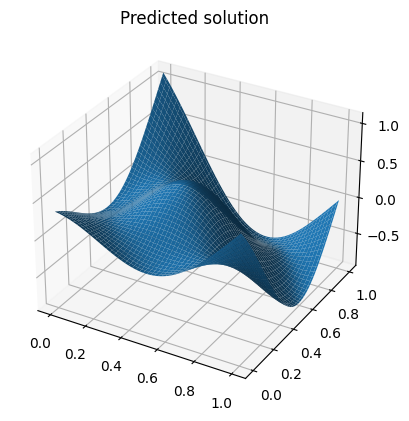

Train Epoch: 40 
Total Loss: 114.5052185059 	Criterion Loss: 105.1241760254 	Boundary Condition Loss 9.381042
Train Epoch: 40 
Total Loss: 59.8889045715 	Criterion Loss: 50.5831146240 	Boundary Condition Loss 9.305791
Train Epoch: 40 
Total Loss: 28.2955741882 	Criterion Loss: 19.1123752594 	Boundary Condition Loss 9.183199
Train Epoch: 40 
Total Loss: 23.9612560272 	Criterion Loss: 14.8229274750 	Boundary Condition Loss 9.138329

After Epoch 40, 	 Actual solution loss: 0.2058086059



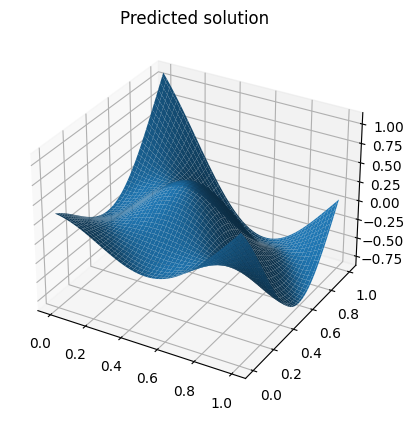

Train Epoch: 41 
Total Loss: 18.5978393555 	Criterion Loss: 9.5399341583 	Boundary Condition Loss 9.057906
Train Epoch: 41 
Total Loss: 18.6410446167 	Criterion Loss: 9.7442598343 	Boundary Condition Loss 8.896786
Train Epoch: 41 
Total Loss: 18.4348907471 	Criterion Loss: 9.5666208267 	Boundary Condition Loss 8.868269
Train Epoch: 41 
Total Loss: 20.7830467224 	Criterion Loss: 12.1033735275 	Boundary Condition Loss 8.679673

After Epoch 41, 	 Actual solution loss: 0.1987702344



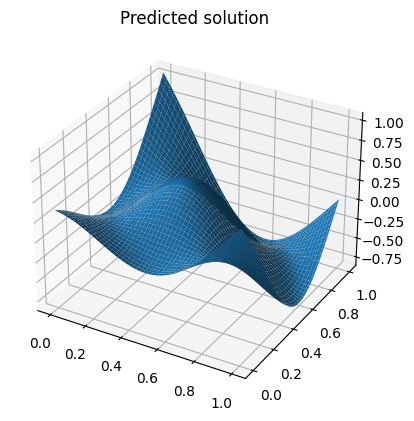

Train Epoch: 42 
Total Loss: 18.6014003754 	Criterion Loss: 10.0356950760 	Boundary Condition Loss 8.565705
Train Epoch: 42 
Total Loss: 18.6623229980 	Criterion Loss: 10.2493677139 	Boundary Condition Loss 8.412954
Train Epoch: 42 
Total Loss: 22.9886093140 	Criterion Loss: 14.7447366714 	Boundary Condition Loss 8.243874
Train Epoch: 42 
Total Loss: 22.8297538757 	Criterion Loss: 14.7421789169 	Boundary Condition Loss 8.087575

After Epoch 42, 	 Actual solution loss: 0.1847174976



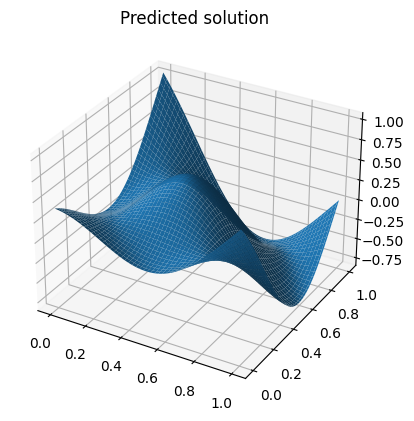

Train Epoch: 43 
Total Loss: 23.5967330933 	Criterion Loss: 15.6193122864 	Boundary Condition Loss 7.977421
Train Epoch: 43 
Total Loss: 19.4747314453 	Criterion Loss: 11.5483121872 	Boundary Condition Loss 7.926420
Train Epoch: 43 
Total Loss: 20.6432132721 	Criterion Loss: 12.8862867355 	Boundary Condition Loss 7.756927
Train Epoch: 43 
Total Loss: 17.8646812439 	Criterion Loss: 10.2581653595 	Boundary Condition Loss 7.606516

After Epoch 43, 	 Actual solution loss: 0.1746793260



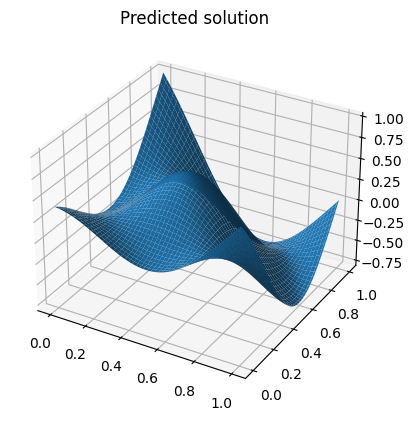

Train Epoch: 44 
Total Loss: 22.3184604645 	Criterion Loss: 14.8241672516 	Boundary Condition Loss 7.494293
Train Epoch: 44 
Total Loss: 17.5397491455 	Criterion Loss: 10.1581916809 	Boundary Condition Loss 7.381557
Train Epoch: 44 
Total Loss: 17.5245590210 	Criterion Loss: 10.2455997467 	Boundary Condition Loss 7.278958
Train Epoch: 44 
Total Loss: 32.3709831238 	Criterion Loss: 25.2257461548 	Boundary Condition Loss 7.145236

After Epoch 44, 	 Actual solution loss: 0.1692618731



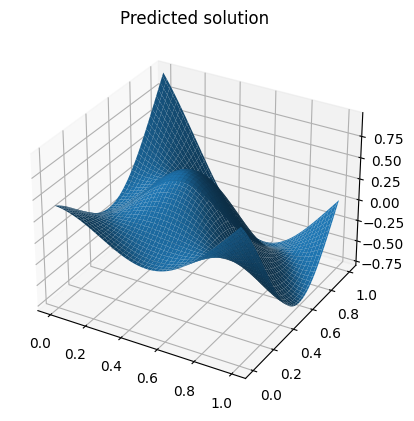

Train Epoch: 45 
Total Loss: 32.9008407593 	Criterion Loss: 25.7265052795 	Boundary Condition Loss 7.174337
Train Epoch: 45 
Total Loss: 23.7007598877 	Criterion Loss: 16.6919860840 	Boundary Condition Loss 7.008773
Train Epoch: 45 
Total Loss: 21.9775352478 	Criterion Loss: 15.0310239792 	Boundary Condition Loss 6.946511
Train Epoch: 45 
Total Loss: 15.1655607224 	Criterion Loss: 8.2760486603 	Boundary Condition Loss 6.889512

After Epoch 45, 	 Actual solution loss: 0.1595233167



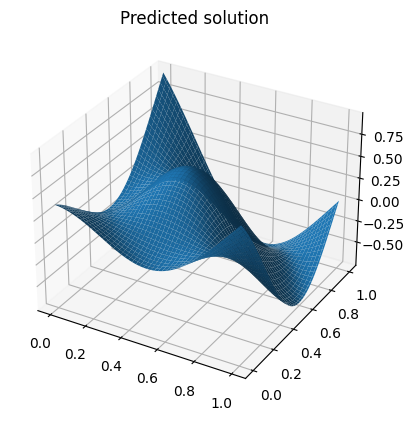

Train Epoch: 46 
Total Loss: 32.4180145264 	Criterion Loss: 25.7134685516 	Boundary Condition Loss 6.704545
Train Epoch: 46 
Total Loss: 18.6133670807 	Criterion Loss: 11.9967479706 	Boundary Condition Loss 6.616619
Train Epoch: 46 
Total Loss: 24.9388809204 	Criterion Loss: 18.3381786346 	Boundary Condition Loss 6.600701
Train Epoch: 46 
Total Loss: 51.7097549438 	Criterion Loss: 45.2829093933 	Boundary Condition Loss 6.426844

After Epoch 46, 	 Actual solution loss: 0.1595593704



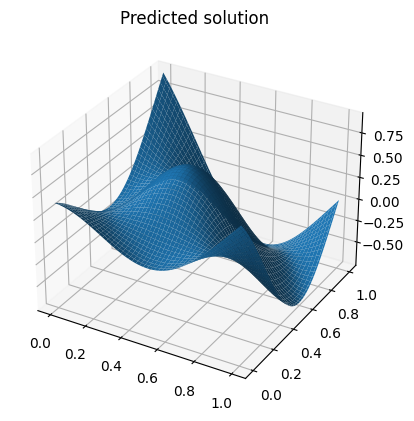

Train Epoch: 47 
Total Loss: 24.7638988495 	Criterion Loss: 18.2157268524 	Boundary Condition Loss 6.548172
Train Epoch: 47 
Total Loss: 14.6627674103 	Criterion Loss: 8.2725677490 	Boundary Condition Loss 6.390200
Train Epoch: 47 
Total Loss: 15.6396656036 	Criterion Loss: 9.3225317001 	Boundary Condition Loss 6.317133
Train Epoch: 47 
Total Loss: 16.3254070282 	Criterion Loss: 10.0964536667 	Boundary Condition Loss 6.228954

After Epoch 47, 	 Actual solution loss: 0.1515628774



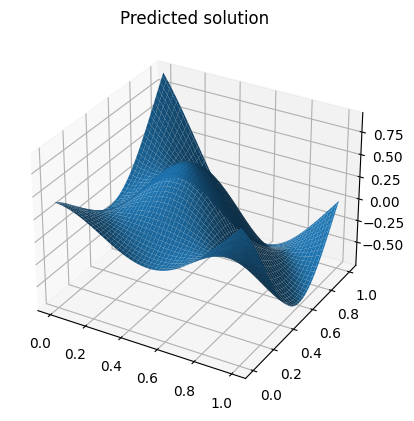

Train Epoch: 48 
Total Loss: 14.8871803284 	Criterion Loss: 8.7378435135 	Boundary Condition Loss 6.149337
Train Epoch: 48 
Total Loss: 55.2840080261 	Criterion Loss: 49.1556053162 	Boundary Condition Loss 6.128404
Train Epoch: 48 
Total Loss: 23.7182388306 	Criterion Loss: 17.6483039856 	Boundary Condition Loss 6.069935
Train Epoch: 48 
Total Loss: 27.5631713867 	Criterion Loss: 21.4892768860 	Boundary Condition Loss 6.073895

After Epoch 48, 	 Actual solution loss: 0.1489270971



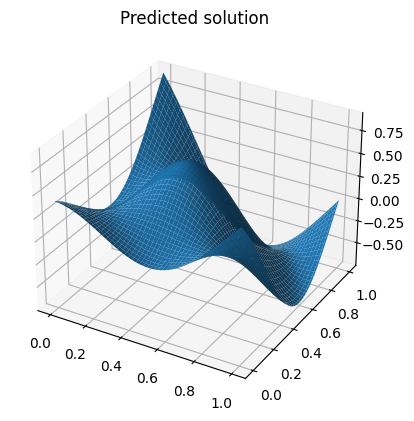

Train Epoch: 49 
Total Loss: 21.6484642029 	Criterion Loss: 15.6709032059 	Boundary Condition Loss 5.977561
Train Epoch: 49 
Total Loss: 13.3040800095 	Criterion Loss: 7.4001021385 	Boundary Condition Loss 5.903978
Train Epoch: 49 
Total Loss: 14.7211723328 	Criterion Loss: 8.8433971405 	Boundary Condition Loss 5.877775
Train Epoch: 49 
Total Loss: 15.5619182587 	Criterion Loss: 9.7934265137 	Boundary Condition Loss 5.768492

After Epoch 49, 	 Actual solution loss: 0.1393765236



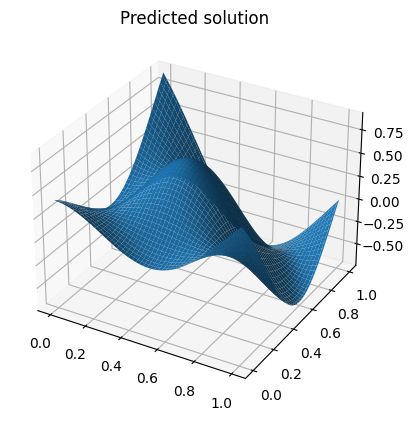

Train Epoch: 50 
Total Loss: 12.3763294220 	Criterion Loss: 6.6590976715 	Boundary Condition Loss 5.717231
Train Epoch: 50 
Total Loss: 15.1722488403 	Criterion Loss: 9.4516973495 	Boundary Condition Loss 5.720551
Train Epoch: 50 
Total Loss: 13.9670391083 	Criterion Loss: 8.3984241486 	Boundary Condition Loss 5.568615
Train Epoch: 50 
Total Loss: 19.6313362122 	Criterion Loss: 14.0968723297 	Boundary Condition Loss 5.534465

After Epoch 50, 	 Actual solution loss: 0.1358612734



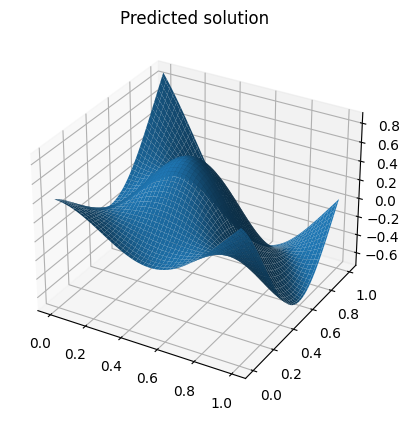

Train Epoch: 51 
Total Loss: 13.3093395233 	Criterion Loss: 7.8151473999 	Boundary Condition Loss 5.494192
Train Epoch: 51 
Total Loss: 19.1020088196 	Criterion Loss: 13.7309808731 	Boundary Condition Loss 5.371028


KeyboardInterrupt: 

In [17]:
epochs = 1000
device = torch.device("cpu")

batchsize = 128 
learning_rate = 1e-3
n = 1000 
eps = 1

batch_flag = True
batch_size = 128

output = train(device,x,y,soln,xb,yb,eps,learning_rate,epochs,batch_flag,batch_size)

In [ ]:
x = np.linspace(0.,1.,100);y = np.linspace(0.,1.,100)
x,y = np.meshgrid(x,y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x,y,soln.reshape(100,100))
plt.show()